In [12]:
import pandas as pd
import subprocess
import glob
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn import metrics

# Part 1: Write hyperparameter optimization script

In [1]:
bash_dir = 'script_2I_primary_plus_ML_gnn_hyperopt.sh'

prefix = 'mkdir primary_plus_ML_val_models/; chemprop_train '
suffix = ' --data_path out/final_model_after_validation/primary_plus_ml_val_trainset.csv --dataset_type classification --features_path out/final_model_after_validation/primary_plus_ml_val_trainset.npz --no_features_scaling --num_folds 3 --ensemble_size 1 --split_type scaffold_balanced --split_sizes 0.8 0.1 0.1 --smiles_columns SMILES --ignore_columns Name --gpu 0 --metric prc-auc --extra_metrics auc'

initlr = [1e-3, 1e-4]
dropout = [0.1, 0.25, 0.4]
hiddensize = [300,500,1000,1500]
ffnnumlayers = [1,2]
depth = [3,4,5]

model_dir = 0
for l in initlr:
    for d in dropout:
        for h in hiddensize:
            for f in ffnnumlayers:
                for de in depth:
                    command = 'mkdir primary_plus_ML_val_models/' + str(model_dir) + '; ' + prefix + '--init_lr ' + str(l) + ' --dropout ' + str(d) + ' --hidden_size ' + str(h) + ' --ffn_num_layers ' + str(f) + ' --depth ' + str(de) + ' --save_dir primary_plus_ML_val_models/' + str(model_dir) + suffix
                    model_dir = model_dir + 1
                    file1 = open(bash_dir,"a") 
                    file1.write(command)
                    file1.write('\n')
                    file1.close()

# Part 2: Find best hyperparameters after running above script

In [3]:
cols = ['num', 'init_lr', 'dropout', 'hiddensize', 'ffn num layers', 'depth']
df = pd.DataFrame(columns = cols)

initlr = [1e-3, 1e-4]
dropout = [0.1, 0.25, 0.4]
hiddensize = [300,500,1000,1500]
ffnnumlayers = [1,2]
depth = [3,4,5]

model_dir = 0
for l in initlr:
    for d in dropout:
        for h in hiddensize:
            for f in ffnnumlayers:
                for de in depth:
                    new_row = [model_dir, l, d, h, f, de]
                    new = pd.DataFrame(new_row).T
                    #new = new.transpose()
                    new.columns = cols
                    df = pd.concat([df, new], ignore_index = True)   
                    model_dir = model_dir + 1
df

,num,init_lr,dropout,hiddensize,ffn num layers,depth
0,0.0,0.001,0.1,300.0,1.0,3.0
1,1.0,0.001,0.1,300.0,1.0,4.0
2,2.0,0.001,0.1,300.0,1.0,5.0
3,3.0,0.001,0.1,300.0,2.0,3.0
4,4.0,0.001,0.1,300.0,2.0,4.0
...,...,...,...,...,...,...
139,139.0,0.0001,0.4,1500.0,1.0,4.0
140,140.0,0.0001,0.4,1500.0,1.0,5.0
141,141.0,0.0001,0.4,1500.0,2.0,3.0
142,142.0,0.0001,0.4,1500.0,2.0,4.0


In [5]:
df['inh mean auc'] = [0] * len(df)
df['kill mean auc'] = [0] * len(df)
df['avg mean auc'] = [0] * len(df)
df['inh mean prc'] = [0] * len(df)
df['kill mean prc'] = [0] * len(df)
df['avg mean prc'] = [0] * len(df)

for name in glob.glob('primary_plus_ML_val_models/**/test_scores.csv', recursive = True): 
    try:
        clean_num = int(name.split("primary_plus_ML_val_models/")[1].split("/")[0])
    except Exception as e:
        print(e)
        print(name)
        continue
    new = pd.read_csv(name) 
    inh_mean_auc = float(list(new['Mean auc'])[0])
    kill_mean_auc = float(list(new['Mean auc'])[1])
    avg_auc = np.average([inh_mean_auc, kill_mean_auc])
    inh_mean_prc = float(list(new['Mean prc-auc'])[0])
    kill_mean_prc = float(list(new['Mean prc-auc'])[1])
    avg_prc = np.average([inh_mean_prc, kill_mean_prc])
    df.iloc[clean_num, df.columns.get_loc("inh mean auc")] = inh_mean_auc
    df.iloc[clean_num, df.columns.get_loc("kill mean auc")] = kill_mean_auc
    df.iloc[clean_num, df.columns.get_loc("avg mean auc")] = avg_auc
    df.iloc[clean_num, df.columns.get_loc("inh mean prc")] = inh_mean_prc
    df.iloc[clean_num, df.columns.get_loc("kill mean prc")] = kill_mean_prc
    df.iloc[clean_num, df.columns.get_loc("avg mean prc")] = avg_prc
    
# the models took up a lot of space, so simply saved this df and we can reload it for the following analysis
df = pd.read_csv('../models/primary_plus_ML_val_models/all_auc_prc_hyperparameters_10_14_2021.csv')

In [6]:
# print best
df = df.sort_values(by = 'kill mean prc', ascending = False)
df

,num,init_lr,dropout,hiddensize,ffn num layers,depth,inh mean auc,kill mean auc,avg mean auc,inh mean prc,kill mean prc,avg mean prc
122,32.0,0.0010,0.25,500.0,1.0,5.0,0.836684,0.903843,0.870264,0.486297,0.401968,0.444132
36,57.0,0.0010,0.40,500.0,2.0,3.0,0.902728,0.916095,0.909411,0.502737,0.372574,0.437656
22,130.0,0.0001,0.40,500.0,2.0,4.0,0.902455,0.925952,0.914203,0.481302,0.367513,0.424408
81,50.0,0.0010,0.40,300.0,1.0,5.0,0.886266,0.903233,0.894750,0.461149,0.356423,0.408786
66,65.0,0.0010,0.40,1000.0,2.0,5.0,0.892073,0.909844,0.900959,0.444958,0.352765,0.398861
...,...,...,...,...,...,...,...,...,...,...,...,...
92,25.0,0.0010,0.25,300.0,1.0,4.0,0.888736,0.890213,0.889475,0.449585,0.190202,0.319893
139,115.0,0.0001,0.25,1500.0,1.0,4.0,0.833528,0.863063,0.848296,0.426340,0.187500,0.306920
115,133.0,0.0001,0.40,1000.0,1.0,4.0,0.867390,0.882374,0.874882,0.454324,0.185031,0.319677
116,1.0,0.0010,0.10,300.0,1.0,4.0,0.873875,0.874657,0.874266,0.412502,0.178726,0.295614


In [8]:
# take a look at the best
df[df['num'] == 32]

,num,init_lr,dropout,hiddensize,ffn num layers,depth,inh mean auc,kill mean auc,avg mean auc,inh mean prc,kill mean prc,avg mean prc
122,32.0,0.001,0.25,500.0,1.0,5.0,0.836684,0.903843,0.870264,0.486297,0.401968,0.444132


# Part 3: Evaluate best train set model on test set

In [10]:
# activate_command = 'conda activate chemprop; '
# for i in [32]: # just do 32 model, but could do all if wanted
#     print(i)
#     run_command = 'python predict.py --test_path ../nontoxic_stat_phase_killing_abx/out/final_model_after_validation/primary_plus_ml_val_testset.csv --checkpoint_dir ../../nontoxic_stat_phase_killing_abx/models/primary_plus_ML_val_models/32/' + str(i) + ' --preds_path ../nontoxic_stat_phase_killing_abx/models/primary_plus_ML_val_models/valtestonpreds_' + str(i) + '.csv --features_path ../nontoxic_stat_phase_killing_abx/out/final_model_after_validation/primary_plus_ml_val_testset.npz --no_features_scaling --smiles_column SMILES --gpu 0 --ensemble_variance'
#     full_command = activate_command + run_command
#     test = subprocess.run(full_command, cwd="../chemprop/", shell=True, capture_output=True)
#     print(test)

In [11]:
cols = ['num', 'init_lr', 'dropout', 'hiddensize', 'ffn num layers', 'depth']
df = pd.DataFrame(columns = cols)

initlr = [1e-3]
dropout = [0.25]
hiddensize = [500]
ffnnumlayers = [1]
depth = [5]

model_dir = 0
for l in initlr:
    for d in dropout:
        for h in hiddensize:
            for f in ffnnumlayers:
                for de in depth:
                    new_row = [model_dir, l, d, h, f, de]
                    new = pd.DataFrame(new_row).T
                    #new = new.transpose()
                    new.columns = cols
                    df = pd.concat([df, new], ignore_index = True)   
                    model_dir = model_dir + 1
df

,num,init_lr,dropout,hiddensize,ffn num layers,depth
0,0.0,0.001,0.25,500.0,1.0,5.0


auroc: 0.8905576208178438
precision recall: 0.1985495982298709


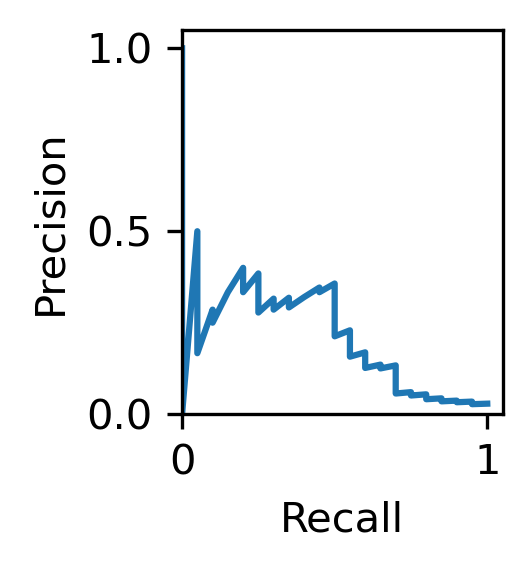

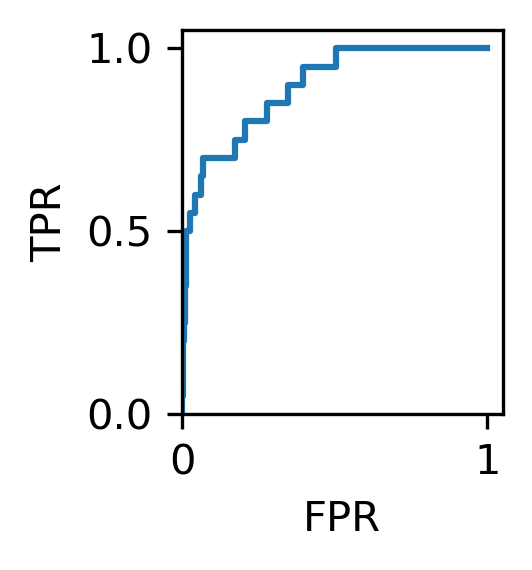

auroc: 0.9414102828825108
precision recall: 0.5434460515102991


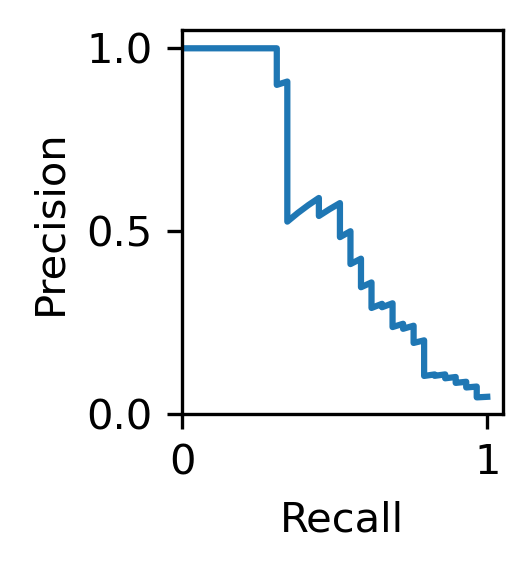

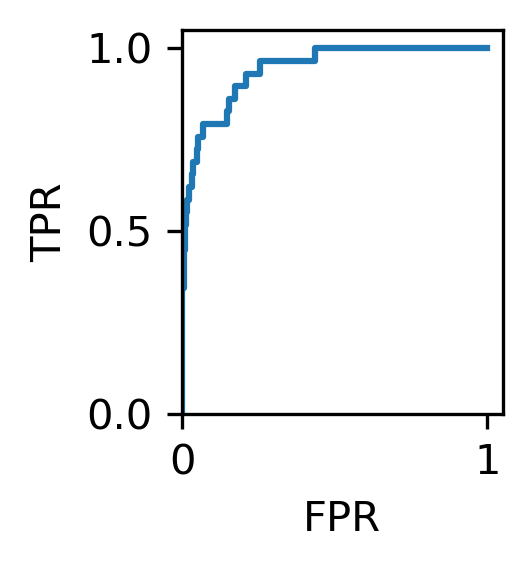

In [13]:
# as before, this code is set up for many models, but here just evaluate 32

def modeleval(y_true, y_pred, name = ''):
    
    new_ytrue = []
    new_ypred = []
    for x, y in zip(y_true, y_pred):
        if y != 'Invalid SMILES':
            new_ytrue.append(x)
            new_ypred.append(y)
    y_true = new_ytrue
    y_pred = new_ypred
    
    # Compute auROC
    auroc = float(roc_auc_score(y_true, y_pred))
    print('auroc: ' + str(auroc))

    # Compute Precision-Recall and plot curve
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr = float(auc(recall,precision))
    print('precision recall: ' + str(pr))

    fig, ax = plt.subplots(figsize = (2,2), dpi = 300)
    plt.clf()
    plt.plot(recall, precision, label='Precision-recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()  
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    fig, ax = plt.subplots(figsize = (2,2), dpi = 300)
    plt.clf()
    plt.plot(fpr, tpr, label='ROC curve')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.show()  
    
    return(auroc, pr)

true = pd.read_csv('../out/final_model_after_validation/primary_plus_ml_val_testset.csv')
true_kill = list(true['hit_kill'])
true_inh = list(true['hit_inh'])

killrocs = []
inhrocs = []
avgrocs = []
killprs = []
inhprs = []
avgprs = []

for i in [32]:
    test = pd.read_csv('../models/primary_plus_ML_val_models/valtestonpreds_' + str(i) + '.csv')
    test_kill = [float(x) if x != 'Invalid SMILES' else x for x in list(test['hit_kill'])]
    test_inh = [float(x) if x != 'Invalid SMILES' else x for x in list(test['hit_inh'])]

    roc_kill, pr_kill = modeleval(true_kill, test_kill)
    roc_inh, pr_inh = modeleval(true_inh, test_inh)
    avgroc = np.average([roc_kill, roc_inh])
    avgpr = np.average([pr_kill, pr_inh])
    killrocs.append(roc_kill)
    inhrocs.append(roc_inh)
    avgrocs.append(avgroc)
    killprs.append(pr_kill)
    inhprs.append(pr_inh)
    avgprs.append(avgpr)

df['inh auroc'] = inhrocs
df['kill auroc'] = killrocs
df['avg auroc'] = avgrocs
df['inh pr'] = inhprs
df['kill pr'] = killprs
df['avg pr'] = avgprs

In [14]:
df

,num,init_lr,dropout,hiddensize,ffn num layers,depth,inh auroc,kill auroc,avg auroc,inh pr,kill pr,avg pr
0,0.0,0.001,0.25,500.0,1.0,5.0,0.94141,0.890558,0.915984,0.543446,0.19855,0.370998


In [15]:
# now go ahead and train final 32 model with script_2I_primary_plus_ML_gnn_final_train.sh